## Dealing with heterozygosity in the genome assembly and outputting final assembly files

Here I want, ultimately, to be able to divide the scaffolds and contigs in the genome assembly into either haploid sections of the genome, or diploid, where I know the primary and alternative contig pairs at the heterozygous positions.

In practice I am never going to get 100% of these, or get 100% of them right. But I will try my best. 

Remember we are aiming for a genome size somewhere around 4.5Gb, so anything around that I think would be a success. 

Lets first take a look at the PurgHaplotigs results in a bit more detail. The program writes a file called *reassignments.tsv. This shows all of the reassigned contigs along with the scaffolds they are thought to belong to. The first few lines look like this:

```
#reassigned_contig           top_hit_contig              second_hit_contig           best_match_coverage  max_match_coverage  reassignment
000000F-002-01               Super-Scaffold_573          Super-Scaffold_381          74.06                2716.33             REPEAT
000000F-023-01               Super-Scaffold_1125         Super-Scaffold_16           99.98                467.11              REPEAT
000001F-001-01               Super-Scaffold_1664         Super-Scaffold_1019         99.94                239.27              HAPLOTIG
000001F-008-01               Super-Scaffold_1664         Super-Scaffold_2560         99.97                213.66              HAPLOTIG
```



The first thing I notice about this file is that a huge number of the reassigned contigs are assigned as "REPEAT". This makes sense. I think a lot of the heterozygosity  in this genome comes from polymorphic repeat insertions and these of course are most likely to break the assembly and creat bubbles. 

In [43]:
from __future__ import division
import numpy as np

In [33]:
reassignments = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/PurgeHaplotigs_outs/Curated_l5_m23_h100.reassignments.tsv", 'r').readlines()

repeats = []
haplotigs = []
kept= []
junk = []

for scaff in reassignments:
    
    if "#" not in scaff:

        scaff_ID = scaff.split()[0]
        top_hit = scaff.split()[1]
        second_hit = scaff.split()[2]
        reassigned_as = scaff.split()[5]

        if reassigned_as == "REPEAT":
            repeats.append(scaff_ID)
        elif reassigned_as == "HAPLOTIG":
            haplotigs.append(scaff_ID)
        elif reassigned_as == "KEEP":
            kept.append(scaff_ID)
        elif reassigned_as == "JUNK":
            junk.append(scaff_ID)
        else:
            print scaff_ID
            
All_haplotigs = repeats+haplotigs+junk

In [32]:
print "%s Scaffolds/contigs were reassigned as REPEATs" % len(repeats)
print "%s Scaffolds/contigs were reassigned as HAPLOTIGSs" % len(haplotigs)
print "%s Scaffolds/contigs were reassigned as JUNK" % len(junk)
print "%s Scaffolds/contigs were kept" % len(kept)

print "Total = ", len(repeats+haplotigs+junk+kept)


7620 Scaffolds/contigs were reassigned as REPEATs
1104 Scaffolds/contigs were reassigned as HAPLOTIGSs
422 Scaffolds/contigs were reassigned as JUNK
12007 Scaffolds/contigs were kept
Total =  21153


Ok, so now I want to compare these results to my linkage mapping analyses. What do we want to know here:

- How many of the LM assigned haplotigs were also assigned by PurgeHaplotigs. 
    - Note here that my assignment of which scaffold to keep may differ as I chose mine based on the number of RADtags mapping to scaffolds.


In [195]:
SbfI_LM_reassignments = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Jeffries_map_markers_and_blast/SbfI_Linkage_map_informed_contig_associations.tsv", 'r').readlines()[1:]  

LM_primaries = []
LM_alts = []
Ntotal = 0

Confirmed_alts = []
Confirmed_primaries = []

AltsPH_as_primsLM = []
primsPH_as_altsLM = []

not_in_LM = []

for line in SbfI_LM_reassignments:
    Ntotal += 1
    
    primary = line.split()[0]
    
    if "quiver" in primary:
        primary = primary.split("|")[0]
        
    LM_primaries.append(primary)
    
    alternative = line.split()[1]
    
    if "quiver" in alternative:
        alternative = alternative.split("|")[0]
        
        
    LM_alts.append(alternative)
    
    
for alternative in All_haplotigs:
    if alternative in LM_alts:
        Confirmed_alts.append(alternative)
        
    elif alternative in LM_primaries:
        primsPH_as_altsLM.append(alternative)
        
    else:
        not_in_LM.append(alternative)
        
for primary in kept:
    if primary in LM_primaries:
        N_primaries += 1
        Confirmed_primaries.append(primary)
    
    elif primary in LM_alts:
        N_primaries += 1
        AltsPH_as_primsLM.append(primary)
    
    else:
        not_in_LM.append(primary)
    
print "Number of primaries in PH assignments = %s" % len(kept) 
print "Number of primaries supported by both approaches = %s (%s%%)" % (len(Confirmed_primaries), np.round((len(Confirmed_primaries)/len(kept))*100, 2))
print "Number of alts in PH assignments = %s" % len(All_haplotigs)
print "Number of LM primaries assigned as alt in PH = %s" % len(AltsPH_as_primsLM)
print "Number of alternatives supported by both approaches = %s" % len(Confirmed_alts)
print "Number of LM alts assigned as primary in PH = %s" % len(primsPH_as_altsLM)
print "Number of scaffolds not in LM analyses = %s" % len(not_in_LM)

print "Total =", (len(Confirmed_primaries)+ len(AltsPH_as_primsLM) + len(Confirmed_alts) + len(primsPH_as_altsLM) + len(not_in_LM))

Number of primaries in PH assignments = 12007
Number of primaries supported by both approaches = 1025 (8.54%)
Number of alts in PH assignments = 9146
Number of LM primaries assigned as alt in PH = 684
Number of alternatives supported by both approaches = 559
Number of LM alts assigned as primary in PH = 55
Number of scaffolds not in LM analyses = 18830
Total = 21153


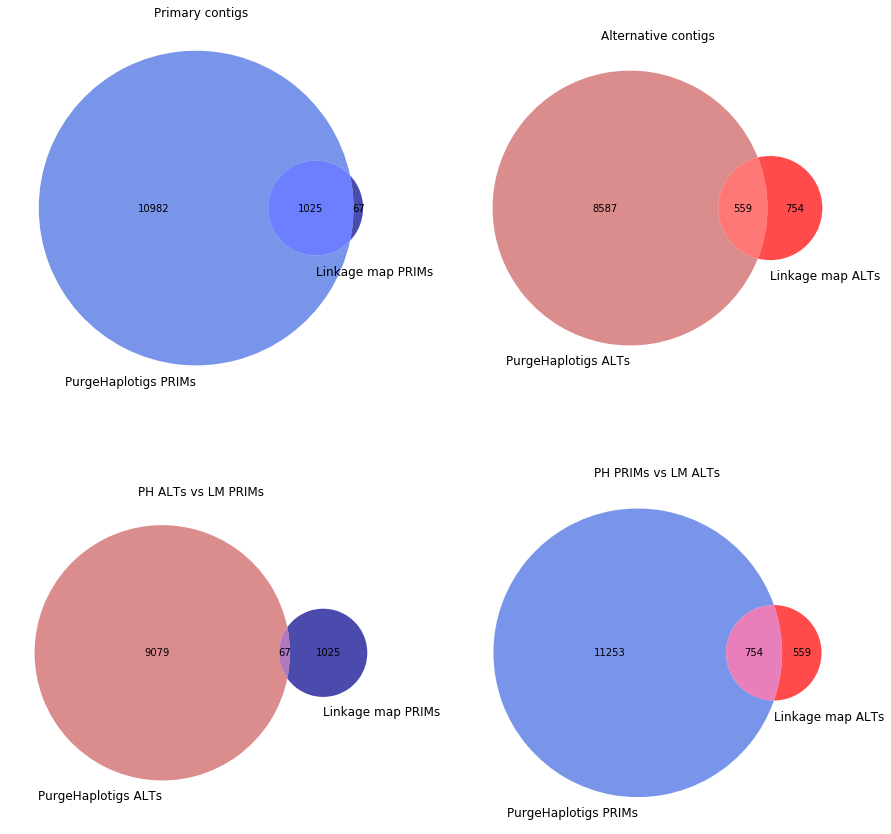

In [196]:
from matplotlib import pyplot as plt
import matplotlib_venn as venn

fig = plt.figure(figsize = (15,15))
fig.add_subplot(2,2,1)
venn.venn2([set(kept), set(LM_primaries)], ["PurgeHaplotigs PRIMs", "Linkage map PRIMs"], ["royalblue", "darkblue"], alpha = 0.7)
plt.title("Primary contigs")

fig.add_subplot(2,2,2)
venn.venn2([set(All_haplotigs), set(LM_alts)], ["PurgeHaplotigs ALTs", "Linkage map ALTs"], ["indianred", "red"], alpha = 0.7)
plt.title("Alternative contigs")

fig.add_subplot(2,2,3)
venn.venn2([set(All_haplotigs), set(LM_primaries)], ["PurgeHaplotigs ALTs", "Linkage map PRIMs"], ["indianred", "darkblue"], alpha = 0.7)
plt.title("PH ALTs vs LM PRIMs")

fig.add_subplot(2,2,4)
venn.venn2([set(kept), set(LM_alts)], ["PurgeHaplotigs PRIMs", "Linkage map ALTs"], ["royalblue", "red"], alpha = 0.7)
plt.title("PH PRIMs vs LM ALTs")

plt.show()

Ok, so there is good agreement between the PH and LM assignments of primary contigs. Almost all of the LM primaries are also called primaries in the PH analysis. 67 are assigned as ALTs in PH but that may be because in my LM analyses I was looking for scaffolds with more mappings rather than just the longest, so that may explain these. 

There is a bigger difference between what I call an ALT in my LM analysis and what PH calls an ALT. Many of what I call an ALT in my LM analysis are assigned as primaries in the PH analysis. However that essentially just means that they were NOT identified as being a haplotig.

So while there is good agreement between the primaries, the two approaches also seem to be doing a good job of identifying complimentary sets of haplotigs. 

## Outputting final assembly fastas

I am confident in my LM assignments, so I think the best way forward is to first assign contigs based on this, and then secondarily assign the remaining contigs based on the PH analysis. That means keeping the 67 PRIMs which were assigned as ALTs in the PH analysis, and assigning the 432 ALTs from the LM which were assigned as PRIMs in the PH analysis as ALTs. 

Also, at this point I have already anchored all possible scaffolds to the linkage map. I did this based only on the PRIMs from the LM analysis where scaffolds were associated. So in the Anchored reference file, all PRIMs which were anchorable are now in chromosome-scale scaffolds. So the rest of the assignments need only be done on the remaining, unanchored scaffolds/contigs. 

So below, I will first make two dictionaries, one for PRIMs and one for ALTs. They will contain these final assignments as well as the co-assignment of the  scaffolds/contigs to be included in the primary or secondary.

I will then go through the anchored assembly and, for all non-anchored scaffolds, I will split them into PRIM and ALT files, whilst simulateneously adding the name of the parent contig into the headers of the ALT contigs where known. 

In [146]:
SbfI_LM_associations = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Jeffries_map_markers_and_blast/SbfI_Linkage_map_informed_contig_associations.tsv", 'r').readlines()[1:]  
EcoRI_LM_associations = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Brelsford_map_markers_and_blast/EcoRI_linkage_map_informed_contig_associations.tsv", 'r').readlines()[1:]  
PstI_LM_associations = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/Linkage_mapped_tag_alignment/Palomar_map_markers_and_blast/PstI_linkage_map_informed_contig_associations.tsv", 'r').readlines()[1:]

LM_PRIMs = []
LM_ALTs = {}

for pair in SbfI_LM_associations+EcoRI_LM_associations+PstI_LM_associations:
    
    PRIM = pair.split()[0]
    ALT = pair.split()[1]
    
    if PRIM not in LM_PRIMs:
        LM_PRIMs.append(PRIM)
    if ALT not in LM_ALTs:
        LM_ALTs[ALT] = PRIM


In [149]:
PH_associations = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/PurgeHaplotigs_outs/Curated_l5_m23_h100.reassignments.tsv", 'r').readlines()

PH_PRIMs = []
PH_ALTs = {}
PH_junk = []

for line in PH_associations:
    
    if "#" not in line:
        reassigned_contig = line.split()[0]
        parent_contig = line.split()[1]
        assignment = line.split()[5]

        if assignment == "KEEP":
            if reassigned_contig not in PH_PRIMs:
                PH_PRIMs.append(reassigned_contig)

        elif assignment in ["REPEAT", "HAPLOTIG"]:

            if parent_contig not in PH_ALTs:
                PH_ALTs[reassigned_contig] = parent_contig

        elif assignment == "JUNK":
            PH_junk.append(reassigned_contig)

        

So, the four potential cases are:

1. Scaffold is assigned to PRIM in both PH and LM
2. Scaffold is assigned to ALT in both LM and PH
3. Scaffold is assigned to PRIM in LM but as ALT PH
4. Scaffold is assigned to PRIM in PH but as ALT in LM

Cases 1 and 2 are easy, just assign to PRIM or ALT respectively and record the parent contig of the ALT.

For Case 3 and 4 I will always take the LM assignment 


In [161]:
from Bio import SeqIO

anchored_genome_assembly = SeqIO.parse(open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/ALLMAPS_working_dir/OUTPUTS_short_pstI_weighted/Combined_maps_pst_short.fasta", 'r'), "fasta")


PRIMs = []
ALTS = {}
junk = []

count = 0

for record in anchored_genome_assembly:
    count += 1
    if record.name in LM_PRIMs:
        PRIMs.append(record.name)
    elif record.name in LM_ALTs:
        ALTS[record.name] = LM_ALTs[record.name]
    elif record.name.split("|")[0] in PH_PRIMs:
        PRIMs.append(record.name)
    elif record.name.split("|")[0] in PH_ALTs:
        ALTS[record.name] = PH_ALTs[record.name.split("|")[0]]
    elif record.name.split("|")[0] in PH_junk:
        junk.append(record.name)
    else:
        print record.name
        
    

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
001372F-001-01|quiver_obj
002385F-004-01|quiver_obj
002973F-001-01|quiver_obj
004305F-001-01|quiver_obj
004349F-003-01|quiver_obj
009132F-001-01|quiver_obj
009946F-001-01|quiver_obj
010572F-001-01|quiver_obj
011829F|quiver_obj
012870F-001-01|quiver_obj
012898F-001-01|quiver_obj
014522F-001-01|quiver_obj
014522F|quiver_subseq_1:87365_obj
014522F|quiver_subseq_87366:166467_obj
014873F-001-01|quiver_obj
014873F|quiver_obj
015212F|quiver_obj
015430F|quiver_obj
015631F|quiver_obj
015654F|quiver_obj
015819F|quiver_obj
016010F|quiver_obj
016051F|quiver_obj
016322F|quiver_obj
016720F|quiver_obj
016796F-001-01|quiver_obj
016859F|quiver_obj
016911F-001-01|quiver_obj
016911F|quiver_obj
017008F|quiver_obj
017081F|quiver_obj
017083F|quiver_obj
017152F|quiver_obj
017238F|quiver_obj
017241F|quiver_obj
017277F|quiver_obj
017588F|quiver_obj
017668F|quiver_obj
017673F|quiver_obj
017782F|quiver_obj
017783F|quiver_obj
017855F|quiver_obj


Ok, so I think we are nearly there. There is a small number of scaffolds which aren't in the PH outputs. I'm not sure where these were lost really. But I will just include them as unplaced. 

So, I am ready to output the final assembly files. My plan is to make two versions of the assembly. One will contain everything, i.e. all scaffolds anchored, unanchored, primaries, alternatives and junk. The second will contain just Anchored and primaries, and in a separate files will be the alternatives and junk. I will then run some tests on mapping to see which version is the most useful/informative. 

## Making the all inclusive assembly file

In [182]:
import gzip

Rtemp_all_inc = open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/Assembly/ANCHORED_PURGED_ASSEMBLY/All_inclusive/Rtemp_all_scaffs.fasta", 'w')

anchored_genome_assembly = SeqIO.parse(open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/ALLMAPS_working_dir/OUTPUTS_short_pstI_weighted/Combined_maps_pst_short.fasta", 'r'), "fasta")

for record in anchored_genome_assembly:
    
    if record.name in PRIMs or record.name.split("|")[0] in PRIMs:
        
        SeqIO.write(record, Rtemp_all_inc, "fasta")
        
    elif record.name in ALTS:
        
        record.description = "ALT_Parent:%s" % ALTS[record.name]
        
        SeqIO.write(record, Rtemp_all_inc, "fasta")
    
    elif record.name.split("|")[0] in ALTS:
        
        record.description = "ALT_Parent:%s" % ALTS[record.name.split("|")[0]]
        
        SeqIO.write(record, Rtemp_all_inc, "fasta")
    
    elif record.name.split("|")[0] in junk:
        
        SeqIO.write(record, Rtemp_all_inc, "fasta")
        
    elif "chr" in record.name:
        
        SeqIO.write(record, Rtemp_all_inc, "fasta")
        
    else:
        #print record.name
        SeqIO.write(record, Rtemp_all_inc, "fasta")
        
        
Rtemp_all_inc.close()


## Making the separated files. 

Here I will output the relevent scaffolds to either a primary assembly file, or a secondary file containing all haplotig content (with putative parent scaffolds in their headers). 

In [184]:
Rtemp_prim = gzip.open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/Assembly/ANCHORED_PURGED_ASSEMBLY/Separated/Rtemp_primaries.fasta.gz", 'w')
Rtemp_alt = gzip.open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/Assembly/ANCHORED_PURGED_ASSEMBLY/Separated/Rtemp_alternatives.fasta.gz", 'w')

anchored_genome_assembly = SeqIO.parse(open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/ALLMAPS_2019/ALLMAPS_working_dir/OUTPUTS_short_pstI_weighted/Combined_maps_pst_short.fasta", 'r'), "fasta")


for record in anchored_genome_assembly:
    
    if record.name in PRIMs or record.name.split("|")[0] in PRIMs:
        
        SeqIO.write(record, Rtemp_prim, "fasta")
        
    elif record.name in ALTS:
        
        record.description = "ALT_Parent:%s" % ALTS[record.name]
        
        SeqIO.write(record, Rtemp_alt, "fasta")
    
    elif record.name.split("|")[0] in ALTS:
        
        record.description = "ALT_Parent:%s" % ALTS[record.name.split("|")[0]]
        
        SeqIO.write(record, Rtemp_alt, "fasta")
    
    elif record.name.split("|")[0] in junk:
        
        SeqIO.write(record, Rtemp_alt, "fasta")
        
    elif "chr" in record.name:
        
        SeqIO.write(record, Rtemp_prim, "fasta")
        
    else:
        #print record.name
        SeqIO.write(record, Rtemp_alt, "fasta")


Rtemp_prim.close()
Rtemp_alt.close()